In [397]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [398]:
import h5py

In [399]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [400]:
from uatu.scattering import *
from kymatio import Scattering2D

In [401]:
from scipy import fftpack
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [402]:
model_path = '/home/sean/Git/uatu/networks/scattering_resnet_max_mode_2_J_2_adv_09.pth'

In [403]:
mode = 2
max_order = 2
J = 2
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
shape = (256, 256)

In [404]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [405]:
scattering = Scattering2D(J=J, shape=shape, max_order=max_order)
if use_cuda:
    scattering = scattering.cuda()

In [406]:
model = Scattering2dResNet(K, J, k=width).to(device)

In [407]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [408]:
model.eval()

Scattering2dResNet(
  (init_conv): Sequential(
    (0): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Conv2d(81, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer_0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [409]:
def log_barrier(x_p, x_o, eps=5., lam=1e6):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=float('Inf')) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [410]:
def get_embedding(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#

############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)

    return model.avgpool(x)

In [411]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad#.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [412]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [413]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [414]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [415]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =5e-3

    for i in range(5000):
        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm() + log_barrier(perturbed_x0, xt) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        # Collect datagrad

        x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.99
            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [416]:
def count_peaks(im):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(1, im.shape[0]-1):
        for j in range(1, im.shape[1]-1): # no peaks on the boundaries i declare
            block = im[i-1:i+2, j-1:j+2].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [417]:
f = h5py.File('../data/UatuLightconeTraining.hdf5', 'r')
mean, std =  f.attrs['mean'], f.attrs['std']
f.close()

In [418]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [419]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [420]:
n_orig = 201#100 
n_targ = n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [421]:
np.random.seed(64)
X = np.random.randn(*X.shape)#*X.std() + X.mean()

In [422]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#targ_X = (targ_X-mean)/(std)

In [423]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [424]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [425]:
cmap = ConvergenceMap(targ_X.squeeze(), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

In [426]:
X = (X- X.mean())/(X.std())*targ_X.std()+targ_X.mean()

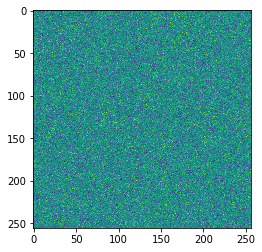

In [427]:
plt.imshow(X.squeeze())

tensor(14.3031, device='cuda:0', grad_fn=<AddBackward0>)
******************** 0 ********************
e 0.00495


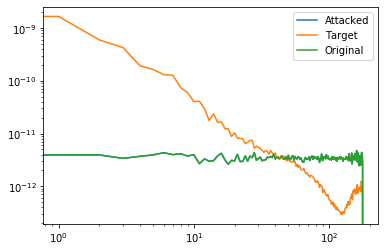

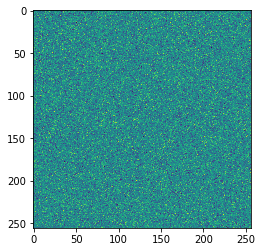

tensor(12.7779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.5598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1819, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.6933, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.0514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.8795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.5301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(71.5746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.7911, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.4292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.8930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.3669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.2947, device='cuda:0', grad

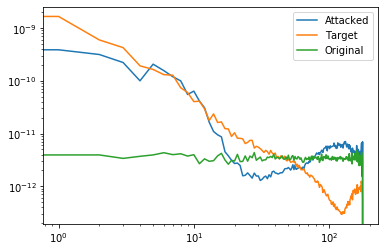

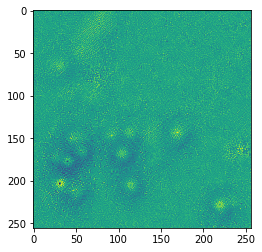

tensor(17.4823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9249, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.5292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7077, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3112, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.6015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.2571, device='cuda:0', grad_fn=<AddBackward0>)
tensor(126.0205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.9132, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4711, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.2587, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8758, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3606, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6093, device='cuda:0', grad_fn=<A

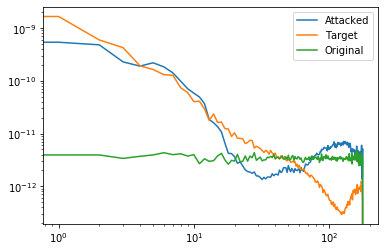

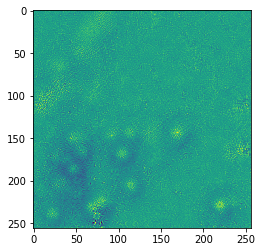

tensor(6.8584, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1300, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5749, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.9973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6846, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.5844, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5634, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2777, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3622, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8835, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6744, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9670, device='cuda:0', grad_fn=<AddBac

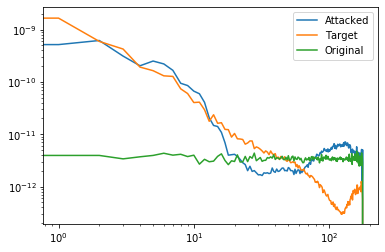

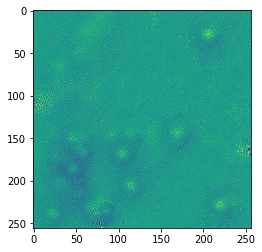

tensor(2.6556, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5442, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4692, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6149, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7077, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4680, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3317, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6736, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4213, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7911, device='cuda:0', grad_fn=<AddBack

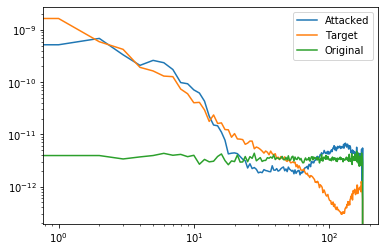

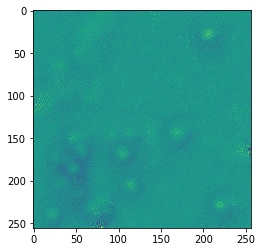

tensor(2.2612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0542, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7423, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7380, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0249, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7414, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0492, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1859, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7155, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7410, device='cuda:0', grad_fn=<AddBack

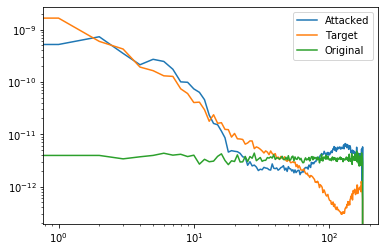

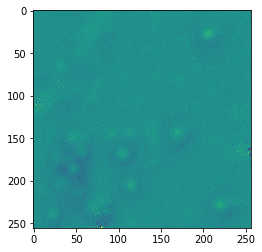

tensor(2.0261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5987, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5128, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5887, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5929, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4982, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5071, device='cuda:0', grad_fn=<AddBack

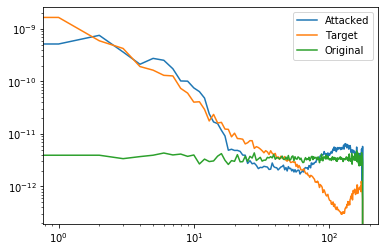

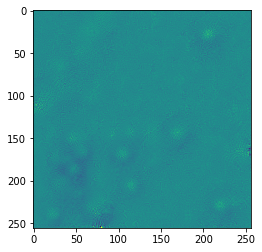

tensor(1.8976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8981, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3774, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8088, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3524, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8249, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7850, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8725, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3284, device='cuda:0', grad_fn=<AddBack

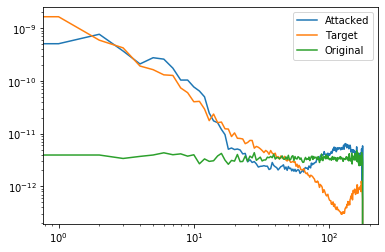

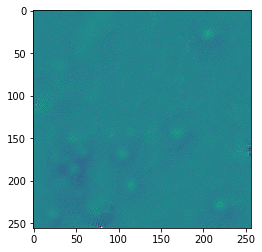

tensor(1.7765, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4411, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7667, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2262, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4397, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7620, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7614, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2108, device='cuda:0', grad_fn=<AddBack

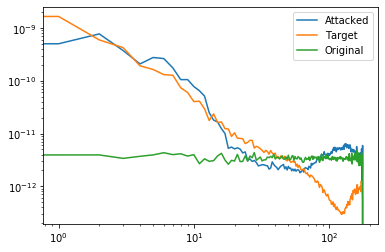

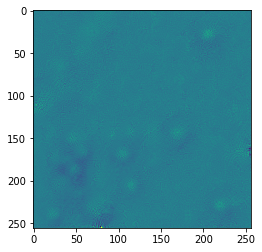

tensor(1.6765, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6741, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7279, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4084, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6604, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0995, device='cuda:0', grad_fn=<AddBack

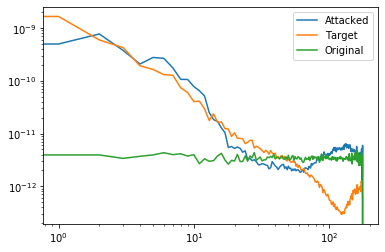

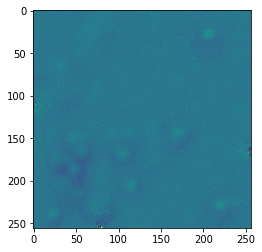

tensor(1.5880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5888, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7124, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0086, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3822, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7226, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0020, device='cuda:0', grad_fn=<AddBack

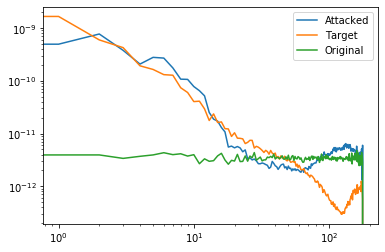

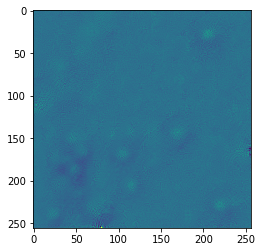

tensor(1.5181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3759, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5128, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9144, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3749, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7285, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5088, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3729, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7226, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9143, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5091, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9133, device='cuda:0', grad_fn=<AddBack

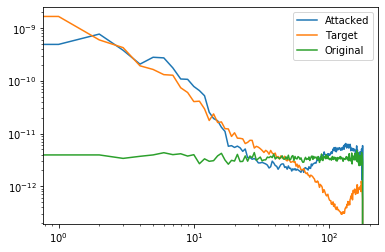

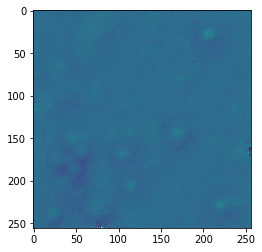

tensor(1.4709, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6756, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4691, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3408, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8598, device='cuda:0', grad_fn=<AddBack

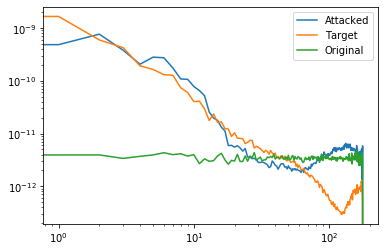

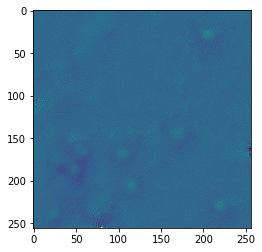

tensor(1.4147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7760, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6639, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7902, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4128, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7794, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6650, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3334, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7755, device='cuda:0', grad_fn=<AddBack

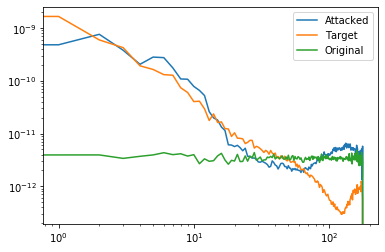

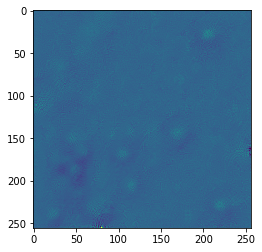

tensor(1.3732, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7279, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6411, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6448, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7323, device='cuda:0', grad_fn=<AddBack

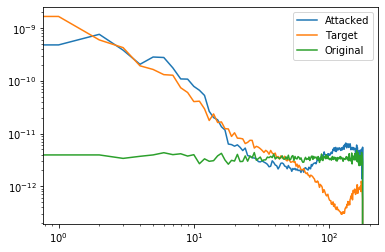

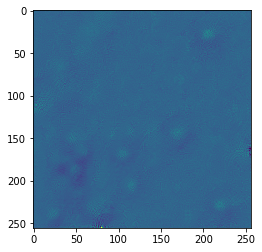

tensor(1.3476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6862, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6090, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3509, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3048, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6856, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6117, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6896, device='cuda:0', grad_fn=<AddBack

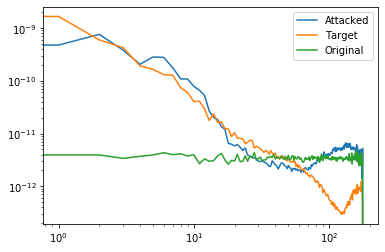

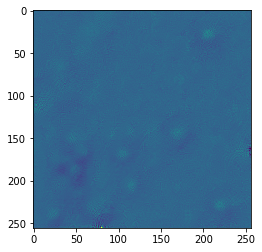

tensor(1.3205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2932, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5872, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6492, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6450, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5837, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3251, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6611, device='cuda:0', grad_fn=<AddBack

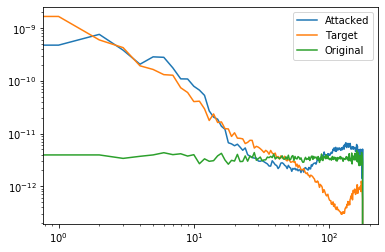

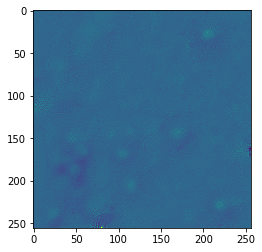

tensor(1.3027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6151, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6120, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5655, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3042, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6245, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2709, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5568, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3081, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6319, device='cuda:0', grad_fn=<AddBack

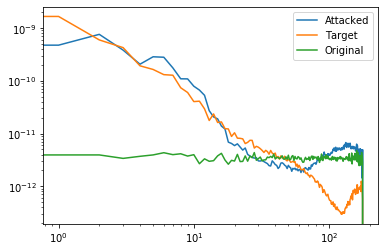

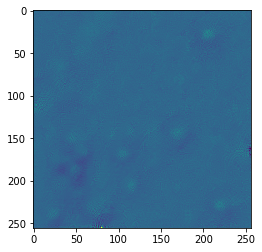

tensor(1.2960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5273, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2492, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2977, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2926, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5951, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5890, device='cuda:0', grad_fn=<AddBack

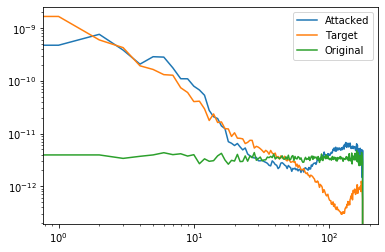

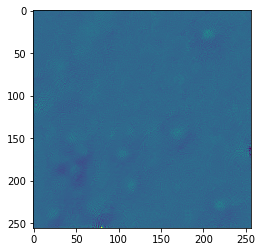

tensor(1.2725, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5782, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5107, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2735, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5696, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2389, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2706, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5679, device='cuda:0', grad_fn=<AddBack

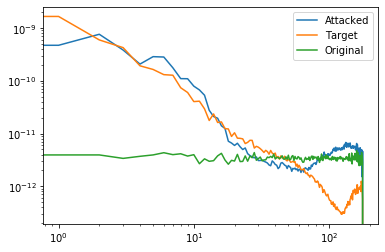

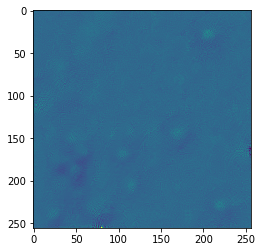

tensor(1.2541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5455, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2245, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4953, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5504, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4954, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2224, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2232, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2584, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5585, device='cuda:0', grad_fn=<AddBack

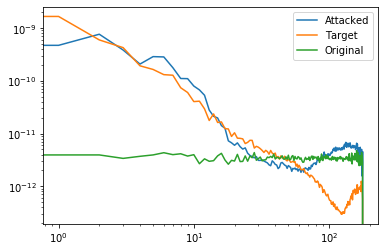

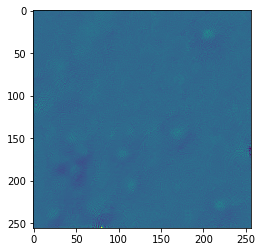

tensor(1.2341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2132, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4727, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2404, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4666, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4626, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5396, device='cuda:0', grad_fn=<AddBack

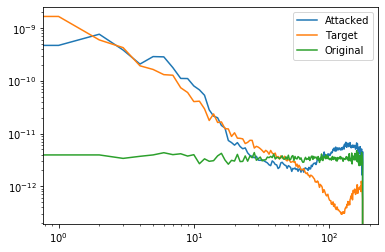

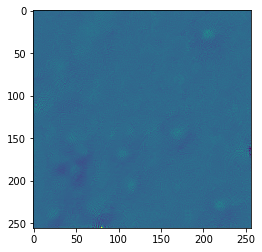

tensor(1.2211, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2263, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1946, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4517, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5137, device='cuda:0', grad_fn=<AddBack

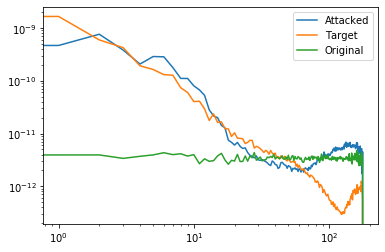

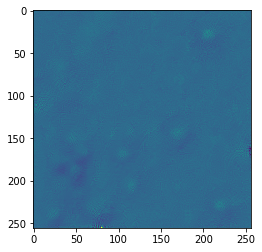

tensor(1.2026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4770, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1886, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4741, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1900, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1920, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4515, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4673, device='cuda:0', grad_fn=<AddBack

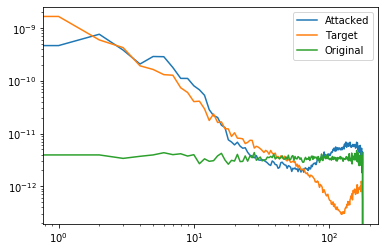

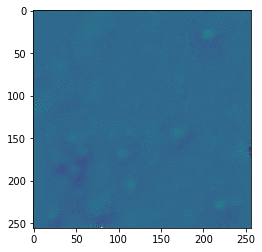

tensor(1.1873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4404, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1838, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4298, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4461, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1799, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4239, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1904, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1794, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4274, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4491, device='cuda:0', grad_fn=<AddBack

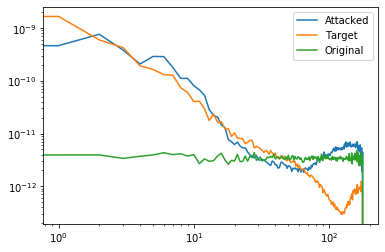

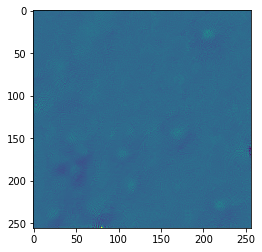

tensor(1.1692, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1711, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4228, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1713, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4257, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1731, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4184, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1717, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4192, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1744, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1725, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4239, device='cuda:0', grad_fn=<AddBack

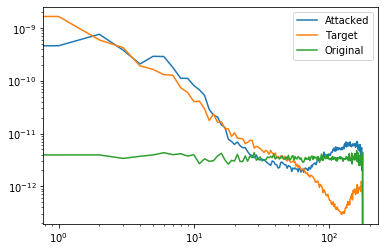

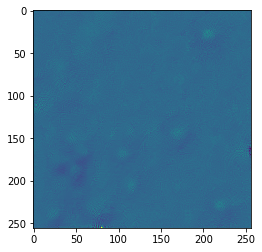

tensor(1.1585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3991, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1636, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1537, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4103, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1674, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4101, device='cuda:0', grad_fn=<AddBack

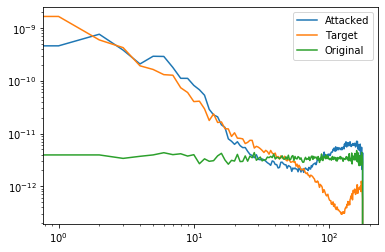

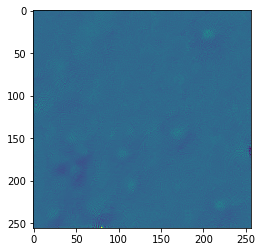

tensor(1.1472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3794, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1539, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3916, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3768, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1517, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3952, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1441, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3742, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1520, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3706, device='cuda:0', grad_fn=<AddBack

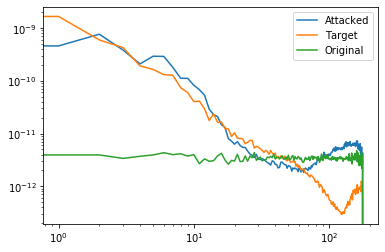

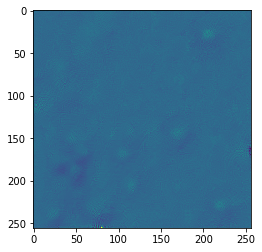

tensor(1.1346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1386, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1386, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1392, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3689, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3758, device='cuda:0', grad_fn=<AddBack

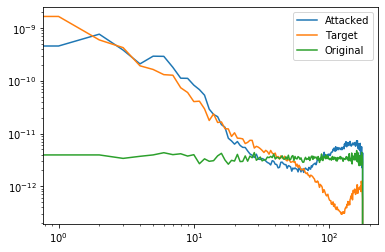

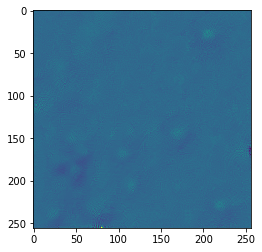

tensor(1.1225, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3454, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1323, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1287, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3511, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3537, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1282, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3438, device='cuda:0', grad_fn=<AddBack

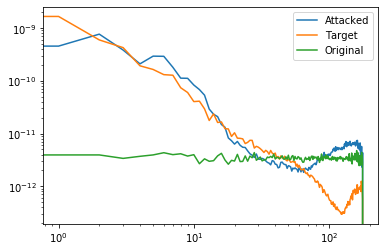

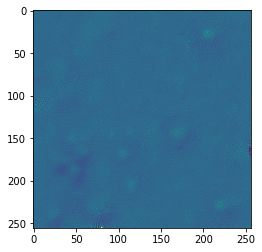

tensor(1.1081, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1244, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1118, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3257, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1217, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1178, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3354, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1194, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3229, device='cuda:0', grad_fn=<AddBack

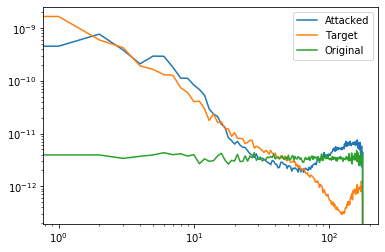

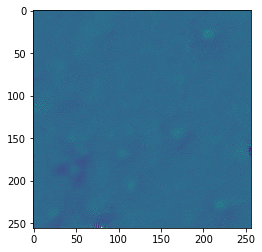

tensor(1.1032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1120, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3237, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1146, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1115, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3118, device='cuda:0', grad_fn=<AddBack

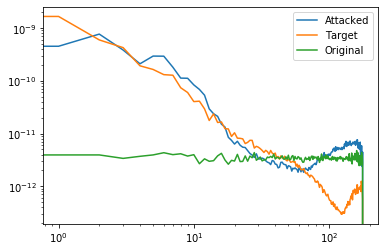

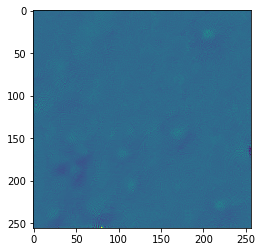

tensor(1.0952, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3227, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3142, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0969, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1090, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0980, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3140, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0972, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2958, device='cuda:0', grad_fn=<AddBack

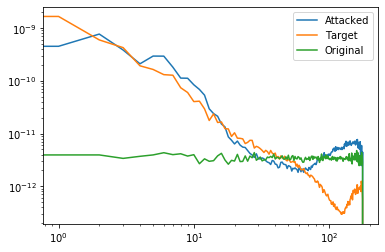

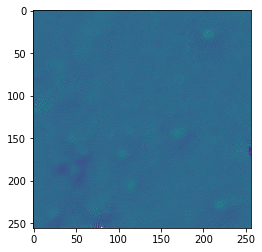

tensor(1.0881, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2902, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0950, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2943, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2983, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0903, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2948, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0904, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2911, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0925, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3040, device='cuda:0', grad_fn=<AddBack

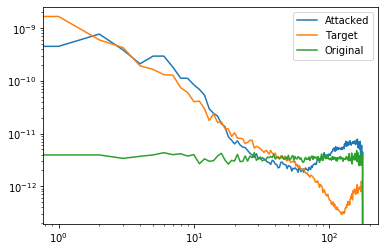

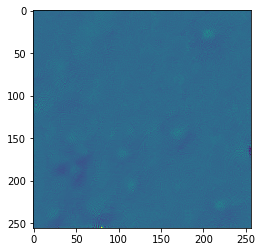

tensor(1.0757, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2597, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2651, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0932, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2686, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0910, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2890, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2753, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2886, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0846, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2763, device='cuda:0', grad_fn=<AddBack

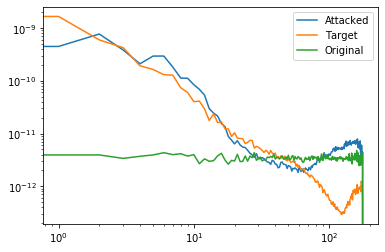

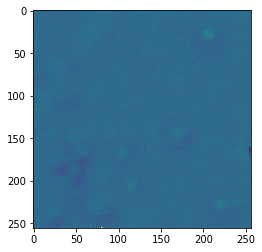

tensor(1.0710, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2583, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0752, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0749, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2666, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0751, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2683, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2732, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0743, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2672, device='cuda:0', grad_fn=<AddBack

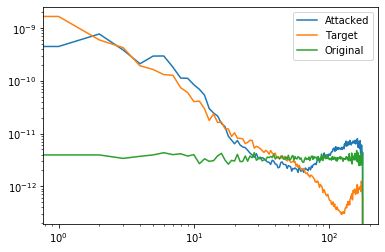

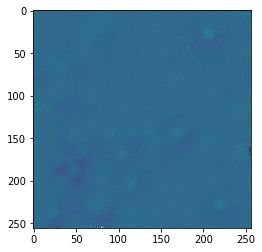

tensor(1.0599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2656, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2610, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0655, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0677, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2570, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0640, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2572, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2535, device='cuda:0', grad_fn=<AddBack

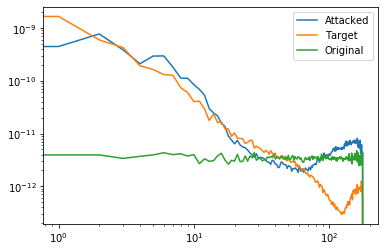

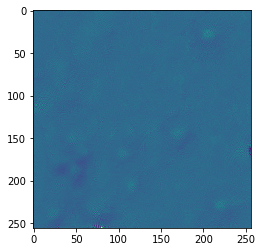

tensor(1.0522, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0629, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2520, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2380, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2394, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0608, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0636, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2371, device='cuda:0', grad_fn=<AddBack

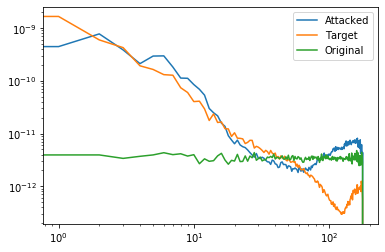

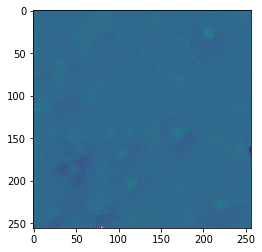

tensor(1.0468, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0570, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2349, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2176, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2429, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0491, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0564, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2227, device='cuda:0', grad_fn=<AddBack

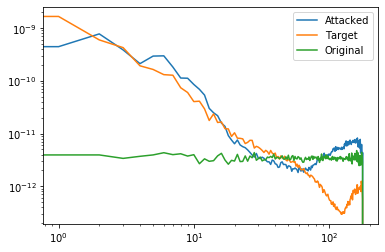

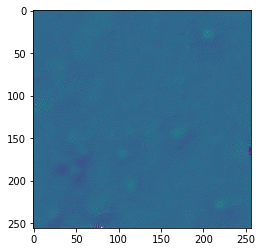

tensor(1.0391, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0441, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2197, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2218, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0458, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0497, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2271, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0415, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2228, device='cuda:0', grad_fn=<AddBack

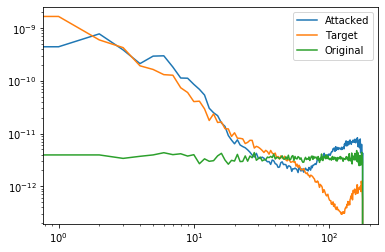

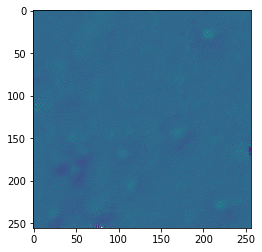

tensor(1.0308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1994, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2098, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2057, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2110, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2107, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0403, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2169, device='cuda:0', grad_fn=<AddBack

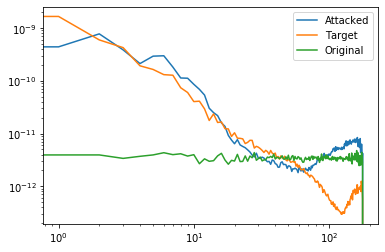

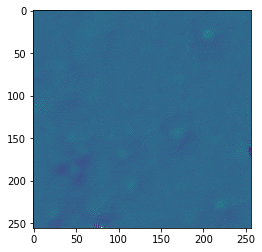

tensor(1.0208, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1885, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0275, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0282, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2036, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2047, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0272, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2006, device='cuda:0', grad_fn=<AddBack

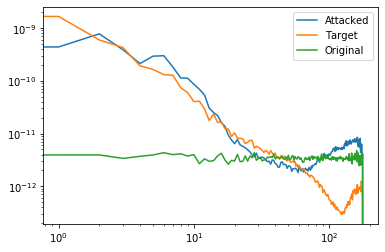

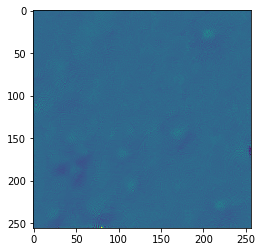

tensor(1.0182, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0209, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1845, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1894, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0217, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1879, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0208, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1882, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1858, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0191, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1839, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1874, device='cuda:0', grad_fn=<AddBack

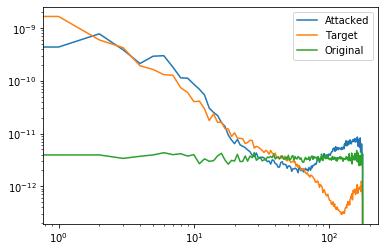

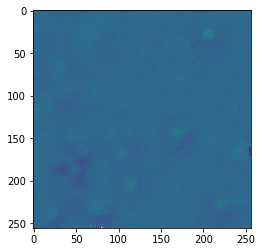

tensor(1.0083, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1667, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0124, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1755, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1737, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1754, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0151, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0142, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1760, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1735, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0132, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1737, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0139, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1799, device='cuda:0', grad_fn=<AddBack

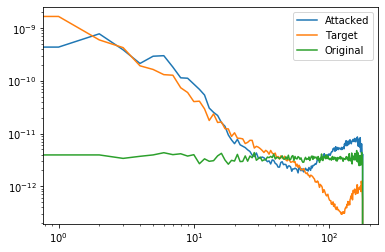

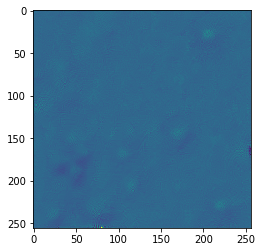

tensor(1.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0077, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0039, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1629, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0057, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0064, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0068, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1717, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1609, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1747, device='cuda:0', grad_fn=<AddBack

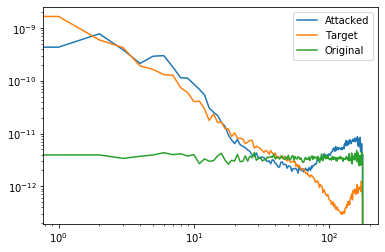

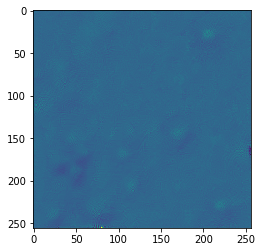

tensor(0.9963, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1508, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9972, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1496, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1584, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1636, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1550, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1559, device='cuda:0', grad_fn=<AddBack

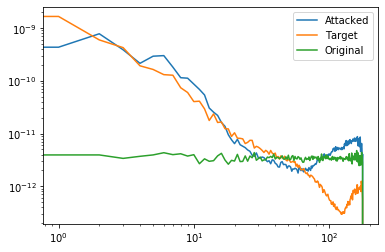

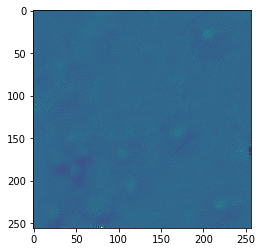

tensor(0.9889, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9950, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1486, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1435, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9932, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1523, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1524, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9912, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1466, device='cuda:0', grad_fn=<AddBack

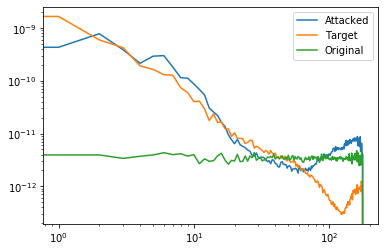

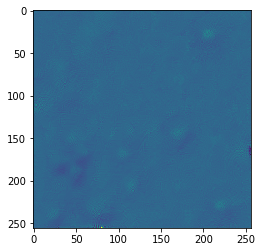

tensor(0.9803, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1275, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9887, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9865, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1394, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9854, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9876, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9887, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1481, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1360, device='cuda:0', grad_fn=<AddBack

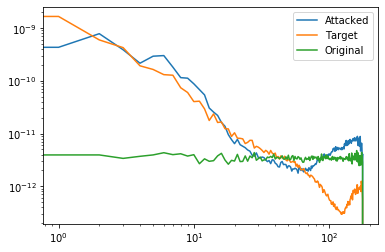

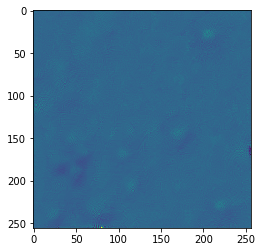

tensor(0.9758, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9809, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1300, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9845, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9809, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1305, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9849, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1326, device='cuda:0', grad_fn=<AddBack

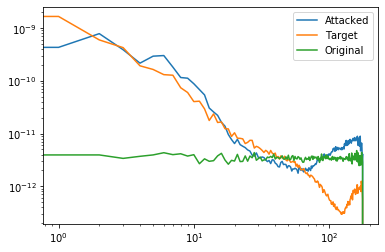

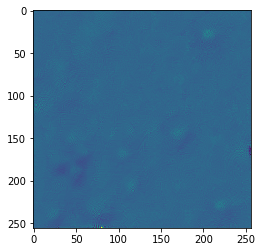

tensor(0.9705, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1117, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9760, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1253, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9764, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9753, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9748, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9747, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1209, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9753, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1259, device='cuda:0', grad_fn=<AddBack

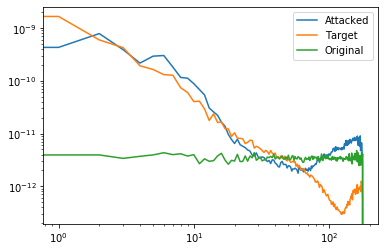

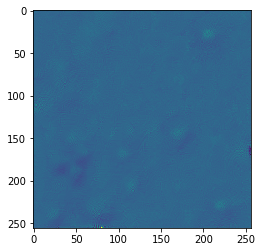

tensor(0.9675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9710, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1103, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1080, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1146, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9694, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1237, device='cuda:0', grad_fn=<AddBack

In [428]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(targ_X).reshape((1, shape[0], shape[1])) )#,\

In [429]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [430]:
print(np.linalg.norm(init_embed-robust_embed))

0.9695715


In [431]:
X_robust.max(), X.max()

(0.46573758, 0.17514520183105464)

In [432]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

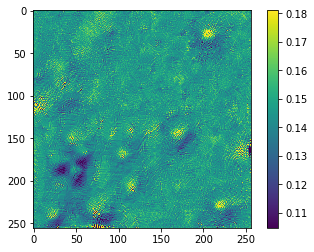

In [433]:
im = plt.imshow(X_robust.squeeze(), vmin = vmin, vmax = vmax)
plt.colorbar(im)

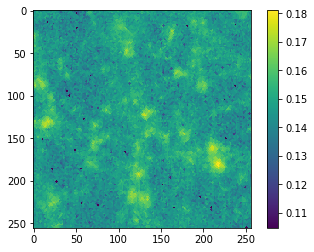

In [434]:
im = plt.imshow(targ_X.squeeze(),vmin = vmin, vmax = vmax)
plt.colorbar(im)

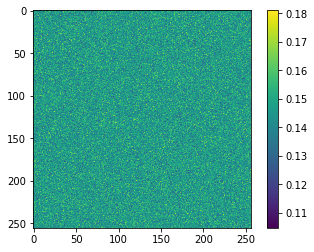

In [435]:
im = plt.imshow(X.squeeze(), vmin = vmin, vmax = vmax)
plt.colorbar(im)

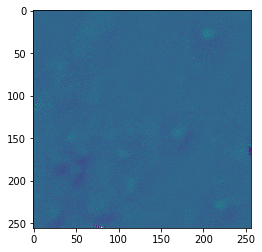

In [436]:
plt.imshow((-X.squeeze() + X_robust.squeeze()))#, vmin = vmin, vmax = vmax)

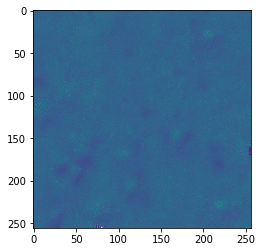

In [437]:
plt.imshow((-targ_X.squeeze() + X_robust.squeeze()))#,vmin = vmin, vmax = vmax)

In [438]:
model(scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.60718626, 1.3117077 ]], dtype=float32)

In [439]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.36057153, 0.97847396]], dtype=float32)

In [440]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [441]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

(0.38753358, 0.5358204)

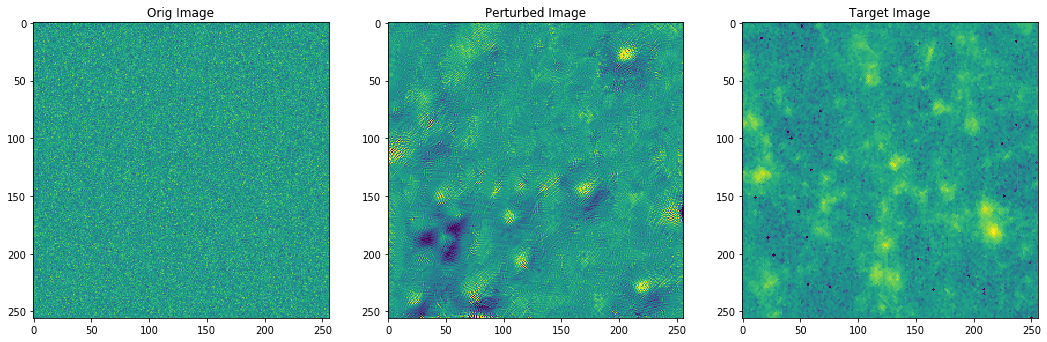

In [442]:
fig = plt.figure(figsize = (18,6))
plt.subplot(131)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(132)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(133)
plt.title('Target Image')
plt.imshow(targ_X.squeeze(), vmin = vmin, vmax= vmax)

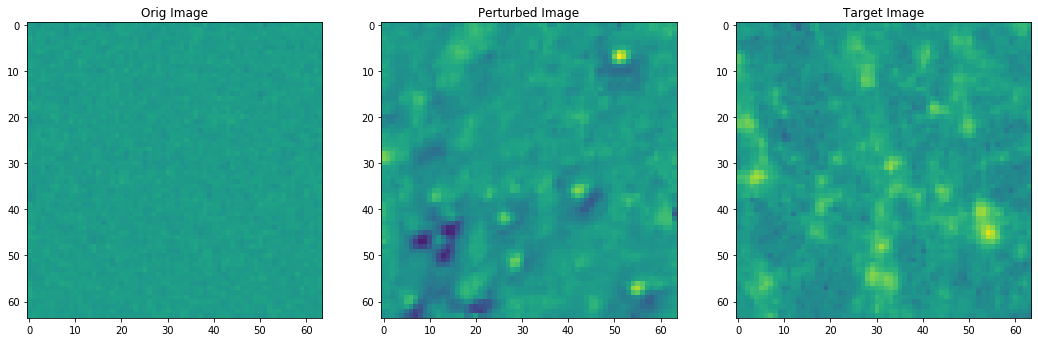

In [443]:
fig = plt.figure(figsize = (18,6))
plt.title('Smoothed Images')
plt.subplot(131)
plt.title('Orig Image')
plt.imshow(orig_s[0,0], vmin = vmin, vmax= vmax)
plt.subplot(132)
plt.title('Perturbed Image')
plt.imshow(robust_s[0,0], vmin = vmin, vmax= vmax)
plt.subplot(133)
plt.title('Target Image')
plt.imshow(targ_s[0,0], vmin = vmin, vmax= vmax)

(7171,)
(13997,)
(7457,)


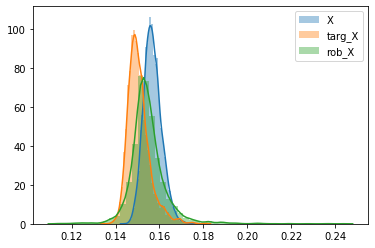

In [444]:
orig_peaks = count_peaks(X.squeeze())
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X');
targ_peaks = count_peaks(targ_X.squeeze())
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X")
rob_peaks = count_peaks(X_robust.squeeze())
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X')
plt.legend(loc = 'best');

(382,)
(187,)
(153,)


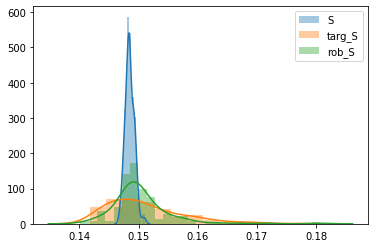

In [445]:
orig_peaks = count_peaks(orig_s[0,0].squeeze())
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'S');
targ_peaks = count_peaks(targ_s[0,0].squeeze())
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_S")
rob_peaks = count_peaks(robust_s[0,0].squeeze())
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_S')
plt.legend(loc = 'best');

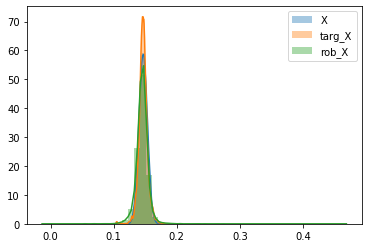

In [446]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(targ_X.flatten(), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

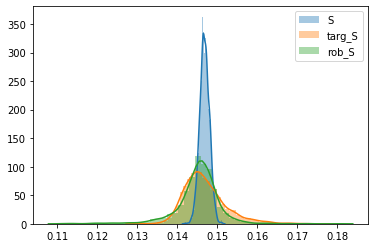

In [447]:
sns.distplot(orig_s[0,0].flatten(), label = 'S')
sns.distplot(targ_s[0,0].flatten(), label = 'targ_S')
sns.distplot(robust_s[0,0].flatten(), label = 'rob_S')
plt.legend(loc='best')

---

In [448]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(targ_X.squeeze())
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

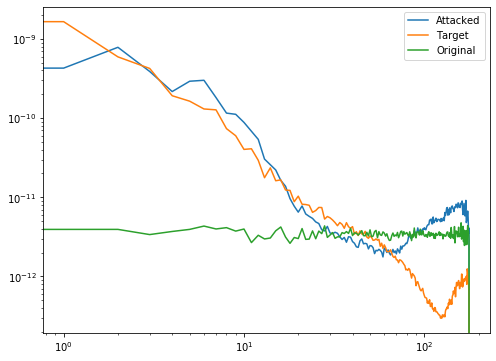

In [449]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();

In [450]:
attacked_ps = image_ps(robust_s[0,0].squeeze())
target_ps = image_ps(targ_s[0,0].squeeze())
normal_ps = image_ps(orig_s[0,0].squeeze())
#diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

(1e-13, 1e-08)

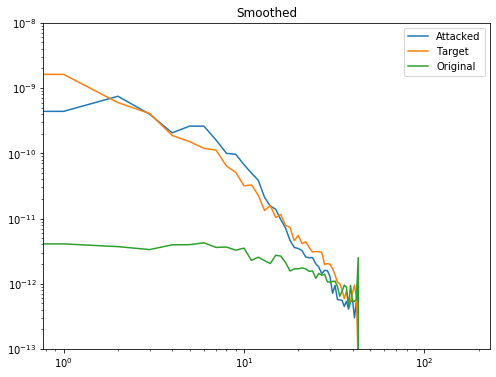

In [451]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
plt.title('Smoothed')
plt.ylim([1e-13, 1e-8])
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();